# Demonstration of OceInterp Lagrangian particle and interpolation functions

<Thomas.Haine@jhu.edu> Jul, Nov '22, Jan '23

# Consider the sources of subpolar North Atlantic water in ECCO.
Specifically, consider these questions and facts:
***

#### What are the sources of eastern subpolar North Atlantic salinity anomalies?
* 2008 was anomalously saline in the eastern SPNA.
* 2016 was anomalously fresh in the eastern SPNA.

#### What are the sources of Labrador Sea deep convection region waters?
* 2010 has shallow convection in the Labrador Sea
* 2016 was deep convection in the Labrador Sea

#### What are the sources of Greenland Sea mode waters?

*** 

This notebook shows how to address these questions using the Lagrangian particle functionality of the `OceInterp` package.

#### Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import OceInterp as oi
import oceanspy as ospy
od = ospy.open_oceandataset.from_catalog('ECCO')

Opening ECCO.
ECCO v4r4 3D dataset, ocean simulations on LLC90 grid


## All the settings of the particles are in the following cell
To integrate forward, set start_time<end_time.

In [2]:
# Change the number of particles here
# N = int(2*4096)     # Production value
N = 512             # Test value
NX = int(np.sqrt(N)/4)
NY = NX 
NZ = int(N/(NX*NY))

# Change the initial lon, lat, depth locations, initial and final times, and number of output times of the particle trajectories here:

# Eastern SPNA, upper ocean. 2016 was a fresh year, 2008 was a saline year:
xa = np.linspace(-30.01,-10.02,NX)      # Longitude (degrees)
ya = np.linspace( 65, 45.01,NY)      # Latitude (degrees)
za = np.linspace( 0,-200.02,NZ)      # Depth (meters)
start_time = '2017-01'
# end_time = '2001-01'    # Production value
end_time = '2016-01'    # Test value
# start_time = '2009-01' 
# end_time = '1992-02'    # Production value
# end_time = '2008-01'    # Test value

# Labrador Sea deep convection region (roughly). 2016 was a deep convection year, 2010 was a shallow convection year (Yashayaev & Loder, 2016)
# xa = np.linspace(-55,-52,NX)      # Longitude (degrees)
# ya = np.linspace( 56, 58,NY)      # Latitude (degrees)
# za = np.linspace( 0,-1000,NZ)      # Depth (meters)
# start_time = '2016-05'
# start_time = '2010-05'
# end_time = '1992-02'

# Greenland Sea deep convection region (roughly)
# xa = np.linspace(-14, -5,NX)      # Longitude (degrees)
# ya = np.linspace( 74, 75,NY)      # Latitude (degrees)
# za = np.linspace( 0,-1000,NZ)      # Depth (meters)

# Setup initial particle positions:
x,y,z = np.meshgrid(xa,ya,za)
x = x.ravel()
y = y.ravel()
z = z.ravel()
print(f"Number of particles = {len(x)} with [{NX}x{NY}x{NZ}] particles in [lon,lat,depth] directions.")

Number of particles = 500 with [5x5x20] particles in [lon,lat,depth] directions.


#### Define the desired output times for the particles.

In [3]:
t000 = np.datetime64('1970-01-01')
# Nsteps = 512    # Production value
Nsteps = 16      # Test value
t_bnds = np.array([np.datetime64(start_time)-t000,np.datetime64(  end_time)-t000])/np.timedelta64(1, 's')
t = np.linspace(t_bnds[0],t_bnds[1],Nsteps)
print(f"Stepping from: {start_time} to {end_time} with {Nsteps} steps.")

Stepping from: 2017-01 to 2016-01 with 16 steps.


#### Integrate particle positions
By default, particles positions are returned at the union of times `t` and the end of the model timestep. To exclude the end of the model timestep, set option `return_in_between = False`

In [4]:
stops,[S,lats,lons,heights] = oi.OceInterp(od._ds,
                                 ['SALT','__particle.lat','__particle.lon','__particle.dep'],
                                 x,y,z,t,
                                 lagrangian = True,
                                 return_in_between = False
                                    )


2016-12-07T14:24:00
500 left 302 left 187 left 117 left 73 left 48 left 35 left 16 left 8 left 5 left 
2016-12-01T06:00:00
500 left 164 left 36 left 3 left 
2016-11-13T04:48:00
500 left 273 left 135 left 55 left 15 left 6 left 
2016-10-31T18:00:00
500 left 256 left 66 left 10 left 1 left 
2016-10-19T19:12:00
500 left 213 left 71 left 14 left 3 left 
2016-10-01T06:00:00
500 left 306 left 139 left 34 left 10 left 4 left 
2016-09-25T09:36:00
500 left 152 left 20 left 1 left 
2016-09-01T00:00:00
500 left 327 left 211 left 92 left 19 left 5 left 4 left 2 left 1 left 1 left 
2016-08-31T18:00:00
500 left 5 left 
2016-08-07T14:24:00
500 left 326 left 182 left 66 left 13 left 
2016-08-01T00:00:00
500 left 162 left 11 left 2 left 
2016-07-14T04:48:00
500 left 304 left 117 left 19 left 4 left 
2016-07-01T06:00:00
500 left 244 left 69 left 7 left 
2016-06-19T19:12:00
500 left 235 left 77 left 14 left 
2016-05-31T18:00:00
500 left 301 left 155 left 50 left 5 left 
2016-05-26T09:36:00
500 left 136 

### Display initial positions

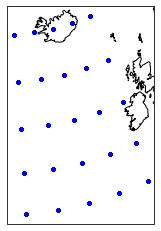

In [5]:
import cartopy.crs as ccrs
projection=ccrs.NearsidePerspective(central_longitude=-35.0,central_latitude=65.0,satellite_height=9000000,false_easting=0, false_northing=0, globe=None)
ax = plt.axes(projection = projection)
ax.plot(x,y,'b.',transform = ccrs.PlateCarree())
ax.coastlines()
plt.show()

### Diagnose which region particles end in:

In [6]:
from shapely.geometry import Polygon, Point, MultiPolygon
import shapefile

Define polygons.

In [7]:
poly = []

AO = [
    (27.5,70.5),
    (20.0,78.8),
    (16.9,79.8),
    (13.5,81.45),
    (-38,82),
    (-75.2,83.1),
    (-118.7,77.3),
    (-139,69.85),
    (-167,65),
    (-176,66),
    (-180,66),
    (-180,90),
    (180,90),
    (180,66),
    (114,62.25),
    (57,56),
]
AO = Polygon(AO)
poly.append(AO)

CAA = [
    (-42.75,69.2),
    (-70.0,66.0),
    (-62,57.75),
    (-79,50),
    (-109,52),
    (-139,69.85),
    (-118.7,77.3),
    (-75.2,83.1),
    (-38,82),
]
CAA = Polygon(CAA)
poly.append(CAA)

NordicSeas = [
    (-38,82),
    (-42.75,69.2),
    (-18.5,65.0),
    (16.2,58.6),
    (27.5,70.5),
    (20.0,78.8),
    (16.9,79.8),
    (13.5,81.45),
]
NordicSeas = Polygon(NordicSeas)
poly.append(NordicSeas)

SPNA = [
    (-54.0,47.0),
    (-5.0,50.0),
    (0.0,46.0),
    (16.2,58.6),
    (-18.5,65.0),
    (-42.75,69.2),
    (-70.0,66.0),
]
SPNA = Polygon(SPNA)
poly.append(SPNA)

STNA = [
     (10.0,0.0),
     (-49.0,0.0),
    (-82.5,8.5),
    (-105.0,29.0),
    (-54.0,47.0),
    (-5.0,50.0),
    (0.0,46.0),
    (-5.5,35.0),
]
STNA = Polygon(STNA)
poly.append(STNA)

# Define region data
domain_dic = {
    0:'Arctic Ocean',
    1:'Canadian Arctic Archipelago',
    2:'Nordic Seas',
    3:'Subpolar North Atlantic',
    4:'Subtropical and tropical North Atlantic',
}
region_ids = [0,1,2,3,4]
color_ids = ['b','c','y','g','r',]

#### Plot regions

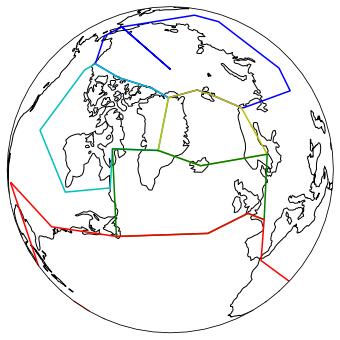

In [8]:
fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection = projection)
for j in region_ids:
    ax.plot(*poly[j].exterior.xy,transform = ccrs.PlateCarree(),color=color_ids[j])
ax.coastlines()
ax.set_global()
plt.show()

#### Compute numbers of particles that are contained in different regions at the end time.

In [9]:
snapx = lons[-1]# make it easier for ploting
snapy = lats[-1]
in_bound=[]
total_particles = 0
for j in range(len(poly)):
    in_bound.append([])
    for i in range(len(snapx)):
        point = Point(snapx[i],snapy[i])
        if poly[j].contains(point):
            in_bound[j].append(i)
            total_particles = total_particles + 1
    print(f" Number of particles in domain: {j}, {domain_dic[j]:40} = {len(in_bound[j]):8d}, fraction = {len(in_bound[j])/len(lons[-1]):.4f}")
print(f" Total number of particles in all domains                                   = {total_particles:8d}, fraction = {total_particles/len(lons[-1]):.4f}")

 Number of particles in domain: 0, Arctic Ocean                             =        0, fraction = 0.0000
 Number of particles in domain: 1, Canadian Arctic Archipelago              =        0, fraction = 0.0000
 Number of particles in domain: 2, Nordic Seas                              =       30, fraction = 0.0600
 Number of particles in domain: 3, Subpolar North Atlantic                  =      281, fraction = 0.5620
 Number of particles in domain: 4, Subtropical and tropical North Atlantic  =      189, fraction = 0.3780
 Total number of particles in all domains                                   =      500, fraction = 1.0000


### Make animation

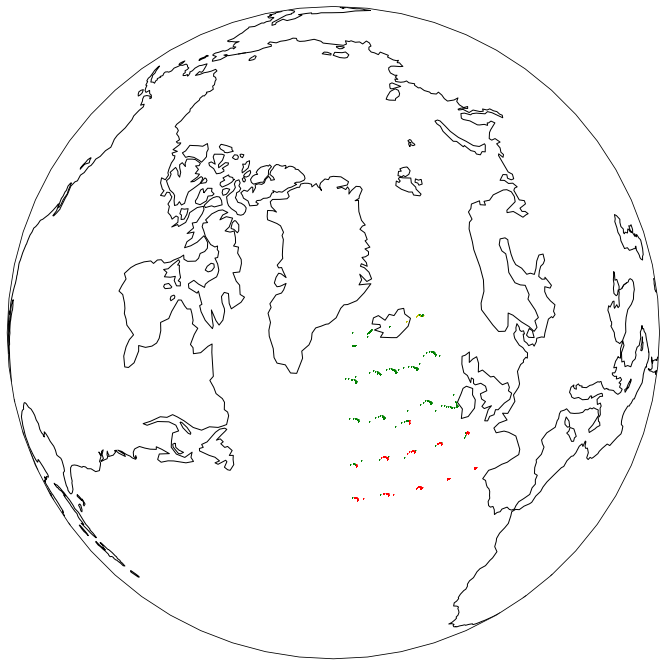

In [10]:
import cartopy.feature as cf
from matplotlib.animation import FuncAnimation
plt.rcParams['animation.embed_limit'] = 128

fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection=projection)
markerSize = 1.0
dots0, = ax.plot(lons[0][in_bound[0]],lats[0][in_bound[0]],'+',color = color_ids[0],ms = markerSize,transform = ccrs.PlateCarree())
dots1, = ax.plot(lons[0][in_bound[1]],lats[0][in_bound[1]],'+',color = color_ids[1],ms = markerSize,transform = ccrs.PlateCarree())
dots2, = ax.plot(lons[0][in_bound[2]],lats[0][in_bound[2]],'+',color = color_ids[2],ms = markerSize,transform = ccrs.PlateCarree())
dots3, = ax.plot(lons[0][in_bound[3]],lats[0][in_bound[3]],'+',color = color_ids[3],ms = markerSize,transform = ccrs.PlateCarree())
dots4, = ax.plot(lons[0][in_bound[4]],lats[0][in_bound[4]],'+',color = color_ids[4],ms = markerSize,transform = ccrs.PlateCarree())

ax.coastlines()
ax.set_xlim([-60,60])
ax.set_ylim([-50,90])
ax.set_global()
plt.show()

def animate(frm):
    dots0.set_data((lons[frm][in_bound[0]],lats[frm][in_bound[0]]))
    dots1.set_data((lons[frm][in_bound[1]],lats[frm][in_bound[1]]))
    dots2.set_data((lons[frm][in_bound[2]],lats[frm][in_bound[2]]))
    dots3.set_data((lons[frm][in_bound[3]],lats[frm][in_bound[3]]))
    dots4.set_data((lons[frm][in_bound[4]],lats[frm][in_bound[4]]))
    ax.set_title(np.timedelta64(round(t[frm]),'s')+t000)
    return dots0, dots1, dots2, dots3, dots4

anim = FuncAnimation(fig,animate,frames = len(lons),interval = 85)

In [11]:
from IPython import display
video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()      

### Plot figure showing start and end positions of particles

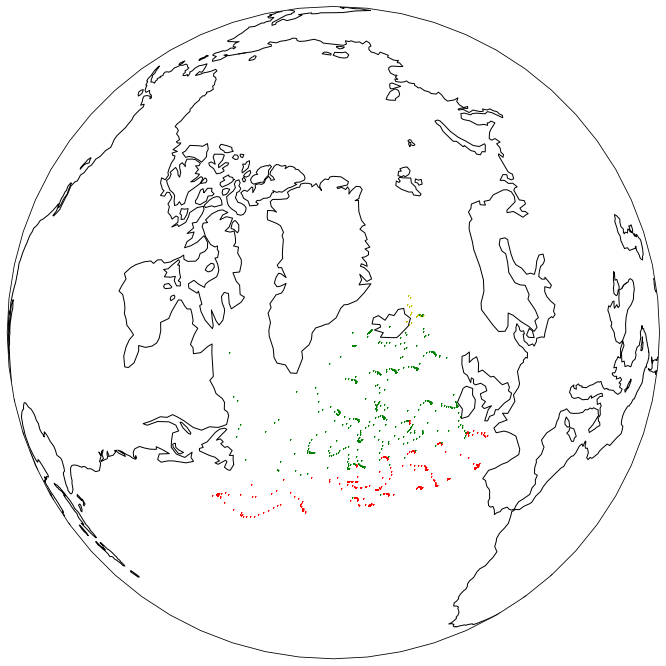

In [12]:
fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection = projection)
dots0, = ax.plot(lons[0][in_bound[0]],lats[0][in_bound[0]],'+',color = color_ids[0],ms = markerSize,transform = ccrs.PlateCarree())
dots1, = ax.plot(lons[0][in_bound[1]],lats[0][in_bound[1]],'+',color = color_ids[1],ms = markerSize,transform = ccrs.PlateCarree())
dots2, = ax.plot(lons[0][in_bound[2]],lats[0][in_bound[2]],'+',color = color_ids[2],ms = markerSize,transform = ccrs.PlateCarree())
dots3, = ax.plot(lons[0][in_bound[3]],lats[0][in_bound[3]],'+',color = color_ids[3],ms = markerSize,transform = ccrs.PlateCarree())
dots4, = ax.plot(lons[0][in_bound[4]],lats[0][in_bound[4]],'+',color = color_ids[4],ms = markerSize,transform = ccrs.PlateCarree())

dots0, = ax.plot(lons[-1][in_bound[0]],lats[-1][in_bound[0]],'+',color = color_ids[0],ms = markerSize,transform = ccrs.PlateCarree())
dots1, = ax.plot(lons[-1][in_bound[1]],lats[-1][in_bound[1]],'+',color = color_ids[1],ms = markerSize,transform = ccrs.PlateCarree())
dots2, = ax.plot(lons[-1][in_bound[2]],lats[-1][in_bound[2]],'+',color = color_ids[2],ms = markerSize,transform = ccrs.PlateCarree())
dots3, = ax.plot(lons[-1][in_bound[3]],lats[-1][in_bound[3]],'+',color = color_ids[3],ms = markerSize,transform = ccrs.PlateCarree())
dots4, = ax.plot(lons[-1][in_bound[4]],lats[-1][in_bound[4]],'+',color = color_ids[4],ms = markerSize,transform = ccrs.PlateCarree())

ax.coastlines()
ax.set_global()
plt.show()